# HuggingFace Dataloader for Doc3D Dataset

These kinds of image datasets are huge with hundred thousands of documents, therefore an **IterableDataset** is needed

In [1]:
from pathlib import Path

import cv2
import datasets
import numpy as np
from PIL import Image
from datasets import IterableDataset
from skimage import io
from skimage.util import img_as_ubyte
from torchvision import transforms as TF
from torchvision.transforms import InterpolationMode

In [2]:
data_root = Path("/mnt/hdd/datasets/documents/Doc3D")

In [3]:
filenames = list(data_root.rglob("img/**/*.png"))  # recursively find all images

In [4]:
def data_generator(n):
    for i in range(n):
        filename = filenames[i].relative_to(data_root / "img")
        image_path = data_root / "img" / filename
        uv_path = data_root / "uv" / filename
        image = io.imread(image_path)[:, :, :3]
        uv = io.imread(uv_path.with_suffix(".exr"))
        mask = (uv[..., 2]).astype(bool)

        x, y, w, h = cv2.boundingRect(img_as_ubyte(mask))

        masked_image = image * mask[..., np.newaxis]
        masked_image = masked_image[y:y + h, x:x + w]
        yield {"image": Image.fromarray(masked_image), }


In [5]:
iterable_dataset = IterableDataset.from_generator(data_generator, gen_kwargs={"n": len(filenames)})

data_augment = TF.Compose(
    [
        # optional data augmentation
        # TF.RandomHorizontalFlip(),
        # TF.RandomVerticalFlip(),
        TF.Resize(size=(288, 288), interpolation=InterpolationMode.BICUBIC),
        # TF.ToTensor(),
    ]
)


In [6]:
def transforms(item):
    item["pixel_values"] = data_augment(item["image"])
    return item

iterable_dataset = iterable_dataset.map(transforms).remove_columns(["image"])

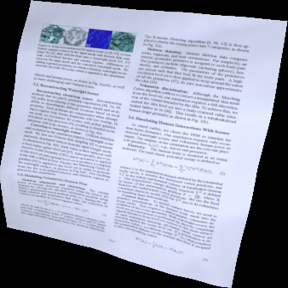

In [7]:
for item in iterable_dataset:
    display(item["pixel_values"])
    break